In [416]:
import pandas as pd
import numpy as np

from statsmodels.formula.api import ols
import statsmodels.stats.diagnostic as cu
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 
import scipy.stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.stattools import durbin_watson

import statsmodels.api as sm
import warnings
warnings.filterwarnings(action='ignore')




In [97]:
real_gdp_log = pd.read_csv("preprocessed_data/real_gdp_log.csv", index_col="Year")
total_work_hours_log = pd.read_csv("preprocessed_data/total_work_hours_log.csv", index_col="Year")
capital_stock_log = pd.read_csv("preprocessed_data/capital_stock_log.csv", index_col="Year")

#employment = pd.read_csv("employment.csv", index_col="Year")


In [98]:
def print_adfuller (x):
    #result = adfuller(x)
    result = adfuller(x, maxlag=1, autolag=None, regression='ct')   #각 데이터 모두 trend가 존재한다고 판단하여 옵션을 "ct"로 줌
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


def print_coint (y, x, t):
    result = coint(y, x, trend=t)  
    print(f'coint T-Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for value in result[2]:
        print('\t: %.3f' % (value))

In [1098]:
korea = pd.concat([real_gdp_log['Korea'], capital_stock_log['Korea'], total_work_hours_log['Korea']], axis=1)
korea.columns = ['lnY', 'lnK', 'lnL']
korea.dropna(axis=0, inplace=True)

korea['trend'] = np.log(range(1, len(korea)+1))
korea['trend'] = korea['trend']

#korea['trend1'] = np.zeros(len(korea))
#x=0
#for i in range(1983, 1997):
#    x=x+1
#    korea.at[i, 'trend1'] = x

korea['intercept'] = np.ones(len(korea))

#korea['before'] = np.zeros(len(korea))
#korea.at[range(1983,1988), 'before'] =1

#korea['before2'] = np.zeros(len(korea))
#korea.at[range(1988,1997), 'before2'] =1

#korea['IMF1'] = np.zeros(len(korea))
#korea.at[range(1997,1999), 'IMF1'] =1

korea['IMF'] = np.zeros(len(korea))
korea.at[range(1997,2005), 'IMF'] =1

#korea['WC'] = np.zeros(len(korea))
#korea.at[range(2002,2008), 'WC'] =1

korea['SPM'] = np.zeros(len(korea))
korea.at[range(2008,2010), 'SPM'] =1

#korea['last'] = np.zeros(len(korea))
#korea.at[range(2018,2020), 'last'] =1

korea

,lnY,lnK,lnL,trend,intercept,IMF,SPM
Year,,,,,,,
1983,26.417000,13.838709,17.468007,0.000000,1.0,0.0,0.0
1984,26.479084,13.932134,17.457334,0.693147,1.0,0.0,0.0
1985,26.478093,14.020440,17.494166,1.098612,1.0,0.0,0.0
1986,26.572349,14.114044,17.507238,1.386294,1.0,0.0,0.0
1987,26.761249,14.217278,17.589812,1.609438,1.0,0.0,0.0
1988,26.991848,14.323022,17.626227,1.791759,1.0,0.0,0.0
1989,27.145788,14.433782,17.642814,1.945910,1.0,0.0,0.0
1990,27.187336,14.561260,17.659299,2.079442,1.0,0.0,0.0
1991,27.254176,14.688802,17.682546,2.197225,1.0,0.0,0.0


ADF test (단위근, 정상성 검정)


: 한국의 lnY, lnL, lnK 각 데이터는 

p-value가 각각 0.14, 0.24, 0.45로

단위근이 존재한다(정상성stationary을 만족하지 못한다)는 귀무가설을 기각하지 못한다

모두 non-stationary하다

In [100]:
print_adfuller(korea['lnY'])
print()
print_adfuller(korea['lnL'])
print()
print_adfuller(korea['lnK'])


ADF Statistic: -2.974
p-value: 0.140
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205

ADF Statistic: -2.683
p-value: 0.243
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205

ADF Statistic: -2.267
p-value: 0.452
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205


Augmented Engle-Granger two-step Cointegration Test (공적분 검정)

: 한국의 lnY와 lnK, lnL 데이터는

검정 결과 p-value값은 0.026으로 


공적분 관계가 존재하지 않는다는 귀무가설(H0)을 유의수준 0.05에서 기각한다.

따라서 공적분 관계가 존재한다.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html

In [117]:
#coint(korea['lnY'], korea[['lnK', 'lnL']], trend='ct')
print_coint(korea['lnY'], korea[['lnK', 'lnL']], 'ct')

coint T-Statistic: -4.349
p-value: 0.026
Critical Values:
	: -5.221
	: -4.462
	: -4.093


In [1099]:
model = ols("lnY ~ lnK + lnL + trend + IMF + SPM -1", data = korea).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    lnY   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.464e+05
Date:                Mon, 06 Jun 2022   Prob (F-statistic):                    1.03e-81
Time:                        07:59:17   Log-Likelihood:                          45.137
No. Observations:                  37   AIC:                                     -80.27
Df Residuals:                      32   BIC:                                     -72.22
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lnK            0.3677      0.070      5.250      0.000       0.225       0.510
lnL            1.2172      0.053     23.033      0.000       1.110       1.325
trend          0.1251      0.054      2.330      0.026       0.016       0.235
IMF           -0.3043      0.031     -9.694      0.000      -0.368      -0.240
SPM           -0.1396      0.058     -2.424      0.021      -0.257      -0.022
==============================================================================
Omnibus:                        4.230   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                2.848
Skew:                          -0.569   Prob(JB):                        0.241
Kurtosis:                       3.742   Cond. No.                         191.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

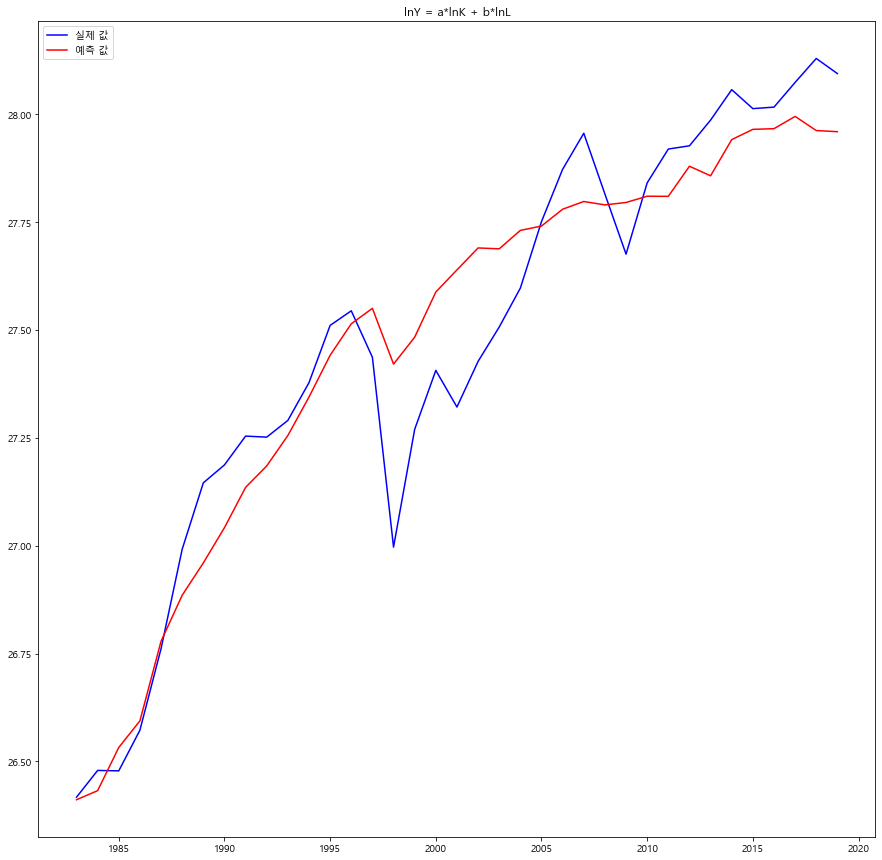

In [1102]:
Y_predict = ols("lnY ~ lnK + lnL", data = korea).fit().predict(korea)

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(korea.index, korea['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')

plt.title("lnY = a*lnK + b*lnL")
plt.legend()

=> lnK, lnL 변수만 사용했을때, 회귀분석 적용 결과

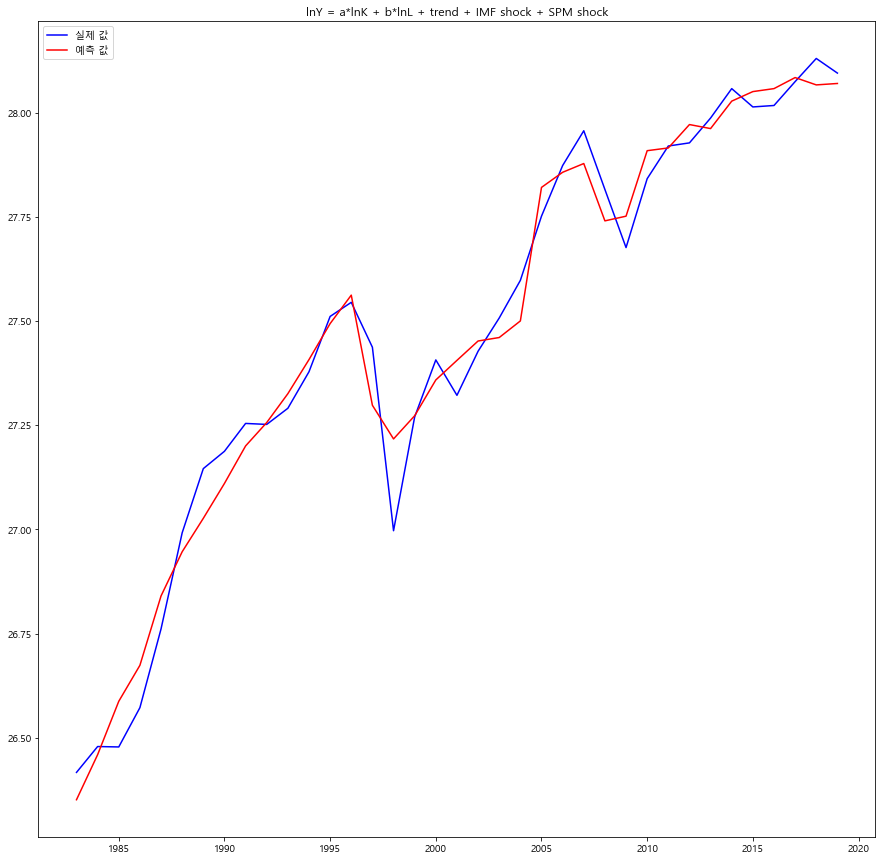

In [1104]:
Y_predict = model.predict(korea)

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(korea.index, korea['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')

plt.title("lnY = a*lnK + b*lnL + trend + IMF shock + SPM shock")
plt.legend()

=> 추세 + 더미변수 등 추가했을때, 최종 결과

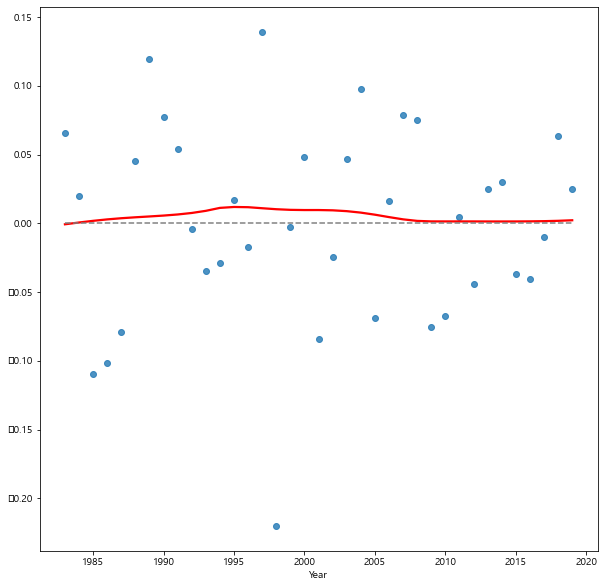

In [1107]:
residual = korea['lnY'] - Y_predict


plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
#plt.plot(residual.index, residual, '--', color='blue')


-> 잔차도를 분석해봤을 떄, 특정 패턴이 나타나지 않으므로 등분산성을 만족한다

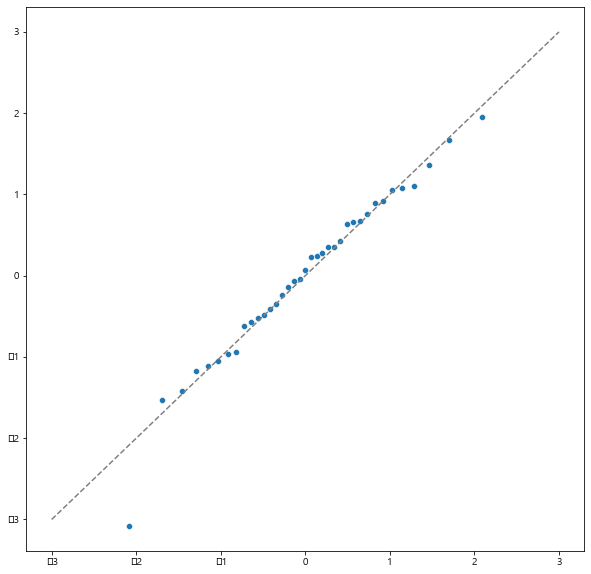

In [1108]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

-> Q-Q plot으로 잔차가 정규분포를 따르는지 확인해본 결과

선에서 벗어나지 않았으므로 정규분포를 따른다

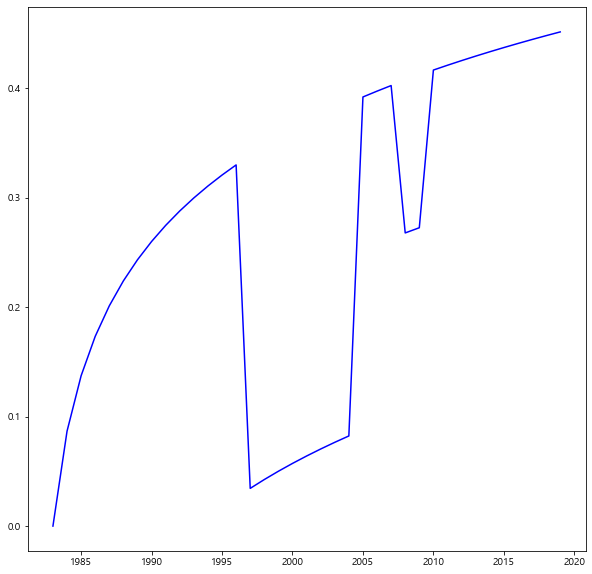

In [1117]:
lnA = korea['trend']*0.1251 + korea['IMF']*(-0.3043) + korea['SPM']*(-0.1396)

#print(lnA)
#for i in lnA.index:
#    lnA[i] = np.exp(lnA[i])

#print(lnA)
plt.plot(lnA.index, lnA, color='blue')


위 회귀분석 식에 따른 lnA (총요소생산성)

In [1125]:
usa = pd.concat([real_gdp_log['USA'], capital_stock_log['USA'], total_work_hours_log['USA']], axis=1).dropna()
usa.columns = ['lnY', 'lnK', 'lnL']
usa['trend'] = (range(1, len(usa)+1))
usa['trend'] = usa['trend']**2

usa['intercept'] = np.ones(len(usa))

usa['before'] = np.zeros(len(usa))
usa.at[range(1960,1964), 'before'] =1

usa['before2'] = np.zeros(len(usa))
usa.at[range(1964,1974), 'before2'] =1

usa['before3'] = np.zeros(len(usa))
usa.at[range(1973,2001), 'before3'] =1

usa['blue'] = np.zeros(len(usa))
usa.at[range(1980,1997), 'blue'] =1

usa['late'] = np.zeros(len(usa))
usa.at[range(2004,2020), 'late'] =1

usa['WC'] = np.zeros(len(usa))
x=0
for i in range(1960, 1965):
    x=x+1
    usa.at[i, 'WC'] = x

#for i in range(1960, 1990):
#    x=x-1
#    usa.at[i, 'WC'] = 0

usa['trend2'] = np.ones(len(usa))
x=0
for i in range(1960, 1967):
    x=x+1
    usa.at[i, 'trend2'] = x

usa['SPM'] = np.zeros(len(usa))
usa.at[range(2008,2009), 'SPM'] =1

usa['Oil'] = np.zeros(len(usa))
usa.at[range(1980,1985), 'Oil'] =1

usa['Corona'] = np.zeros(len(usa))
usa.at[range(2011,2020), 'Corona'] =1

usa['trend9'] = np.zeros(len(usa))
usa.at[range(1960,1980), 'trend9'] =1

usa

,lnY,lnK,lnL,trend,intercept,before,before2,before3,blue,late,WC,trend2,SPM,Oil,Corona,trend9
Year,,,,,,,,,,,,,,,,
1960,28.871477,16.504169,18.670620,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1961,28.894216,16.537153,18.664504,4,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0
1962,28.953428,16.572959,18.688697,9,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,1.0
1963,28.996488,16.610436,18.710573,16,1.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,1.0
1964,29.052868,16.650116,18.734587,25,1.0,0.0,1.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,1.0
1965,29.114903,16.692038,18.764545,36,1.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0
1966,29.177878,16.734955,18.784636,49,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0
1967,29.202571,16.773725,18.792927,64,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1968,29.249454,16.812002,18.807879,81,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


ADF test (단위근, 정상성 검정)


: 미국 lnY, lnL, lnK 각 데이터는 

p-value가 각각 0.36, 0.88, 0.66으로

단위근이 존재한다(정상성stationary을 만족하지 못한다)는 귀무가설을 기각하지 못한다

따라서 non-stationary하다

In [73]:
print_adfuller(usa['lnY'])
print()
print_adfuller(usa['lnK'])
print()
print_adfuller(usa['lnL'])


ADF Statistic: -2.429
p-value: 0.364
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173

ADF Statistic: -1.319
p-value: 0.883
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173

ADF Statistic: -1.872
p-value: 0.669
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173


Augmented Engle-Granger two-step Cointegration Test (공적분 검정)

: 미국의 lnY와 lnK, lnL 데이터는

검정 결과 p-value값은 0.097로 

공적분 관계가 존재하지 않는다는 귀무가설(H0)을 유의수준 0.1에서 기각할 수 있으며

공적분 관계가 존재한다.

In [74]:
#coint(usa['lnY'], usa[['lnK', 'lnL']], trend='ctt')
print_coint(usa['lnY'], usa[['lnK', 'lnL']], 'ctt')

coint T-Statistic: -4.188
p-value: 0.097
Critical Values:
	: -5.412
	: -4.729
	: -4.389


In [1126]:
model = ols("lnY ~ lnK + lnL + trend ", data = usa).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.364e+04
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           3.81e-80
Time:                        08:09:41   Log-Likelihood:                 152.82
No. Observations:                  60   AIC:                            -297.6
Df Residuals:                      56   BIC:                            -289.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.1697      0.827      8.670      0.000       5.513       8.826
lnK            0.7287      0.057     12.706      0.000       0.614       0.844
lnL            0.5203      0.091      5.724      0.000       0.338       0.702
trend       5.218e-05   7.66e-06      6.813      0.000    3.68e-05    6.75e-05
==============================================================================
Omnibus:                        0.096   Durbin-Watson:                   0.335
Prob(Omnibus):                  0.953   Jarque-Bera (JB):                0.294
Skew:                          -0.011   Prob(JB):                        0.863
Kurtosis:                       2.658   Cond. No.                     5.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Durbin Watson :  0.3352241432458882


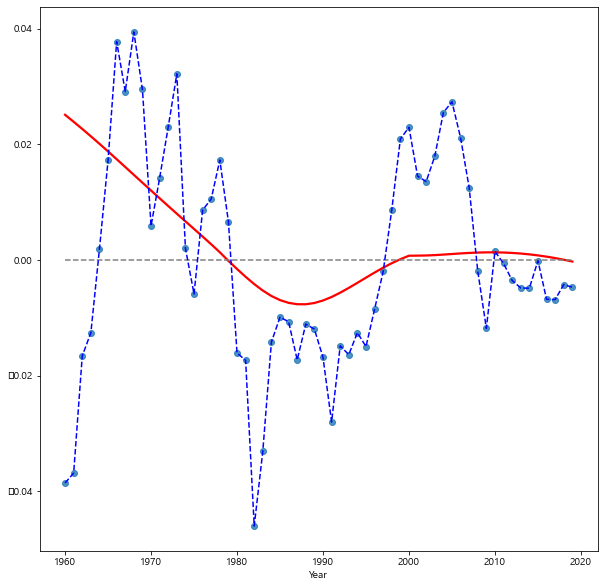

In [1128]:
Y_predict = model.predict(usa)
residual = usa['lnY'] - Y_predict

print("Durbin Watson : ", durbin_watson(residual))

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
#sns.regplot(usa['lnY'], residual, lowess=True, line_kws={'color': 'red'})

plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
#plt.plot([usa['lnY'].min(), usa['lnY'].max()], [0, 0], '--', color='grey')

plt.plot(residual.index, residual, '--', color='blue')


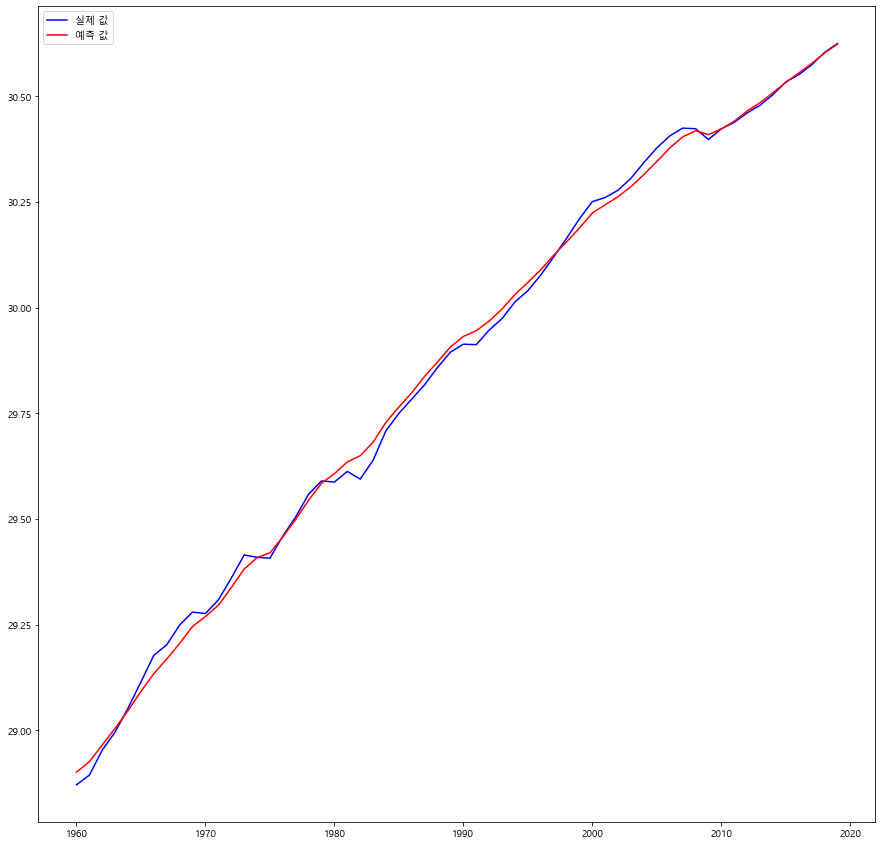

In [1121]:
plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(usa.index, usa['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')
plt.legend()


c:\Users\kimjonghwi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\kimjonghwi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


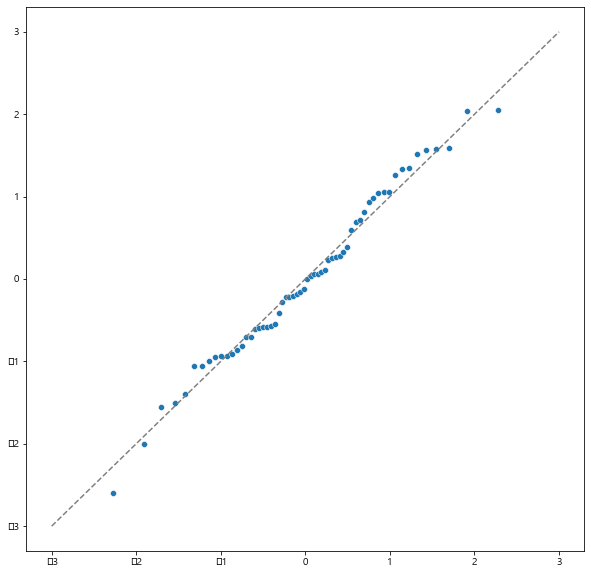

In [320]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [367]:
japan = pd.concat([real_gdp_log['Japan'], capital_stock_log['Japan'], total_work_hours_log['Japan']], axis=1).dropna()
japan.columns = ['lnY', 'lnK', 'lnL']
japan['trend'] = (range(1, len(japan)+1))
japan['trend'] = japan['trend']

japan['intercept'] = np.ones(len(japan))

japan['first_dummy'] = np.zeros(len(japan))
japan.at[range(1991,2011), 'first_dummy'] =1
japan


,lnY,lnK,lnL,trend,intercept,first_dummy
Year,,,,,,
1970,26.919705,15.477723,18.553957,1,1.0,0.0
1971,26.991862,15.595414,18.557637,2,1.0,0.0
1972,27.218209,15.708076,18.557096,3,1.0,0.0
1973,27.405071,15.819373,18.566948,4,1.0,0.0
1974,27.320410,15.902431,18.533216,5,1.0,0.0
1975,27.334878,15.974494,18.518739,6,1.0,0.0
1976,27.374650,16.041853,18.535403,7,1.0,0.0
1977,27.516953,16.105077,18.549286,8,1.0,0.0
1978,27.812007,16.169214,18.558759,9,1.0,0.0


ADF test (단위근, 정상성 검정)


: 일본 lnY, lnL, lnK 각 데이터는 

p-value가 각각 0.78, 0.87, 0.81으로

단위근이 존재한다(정상성stationary을 만족하지 못한다)는 귀무가설을 기각하지 못한다

따라서 non-stationary하다

In [80]:
print_adfuller(japan['lnY'])
print()
print_adfuller(japan['lnK'])
print()
print_adfuller(japan['lnL'])


ADF Statistic: -1.613
p-value: 0.787
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183

ADF Statistic: -1.350
p-value: 0.875
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183

ADF Statistic: -1.546
p-value: 0.813
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183


Augmented Engle-Granger two-step Cointegration Test (공적분 검정)

: 일본의 lnY와 lnK, lnL 데이터는

검정 결과 p-value값은 0.048로 

공적분 관계가 존재하지 않는다는 귀무가설(H0)을 유의수준 0.05에서 기각할 수 있으며

공적분 관계가 존재한다.

In [81]:
#coint(japan['lnY'], japan[['lnK', 'lnL']])
print_coint(japan['lnY'], japan[['lnK', 'lnL']], 'c')

coint T-Statistic: -3.754
p-value: 0.048
Critical Values:
	: -4.602
	: -3.920
	: -3.581


In [372]:
model = ols("lnY ~ lnK + lnL", data = japan).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     524.9
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           7.09e-33
Time:                        03:29:50   Log-Likelihood:                 21.643
No. Observations:                  50   AIC:                            -37.29
Df Residuals:                      47   BIC:                            -31.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0984      9.287      0.549      0.586     -13.584      23.781
lnK            1.6186      0.050     32.268      0.000       1.518       1.719
lnL           -0.1886      0.494     -0.381      0.705      -1.183       0.806
==============================================================================
Omnibus:                        0.696   Durbin-Watson:                   0.437
Prob(Omnibus):                  0.706   Jarque-Bera (JB):                0.780
Skew:                          -0.147   Prob(JB):                        0.677
Kurtosis:                       2.463   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

c:\Users\kimjonghwi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


c:\Users\kimjonghwi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


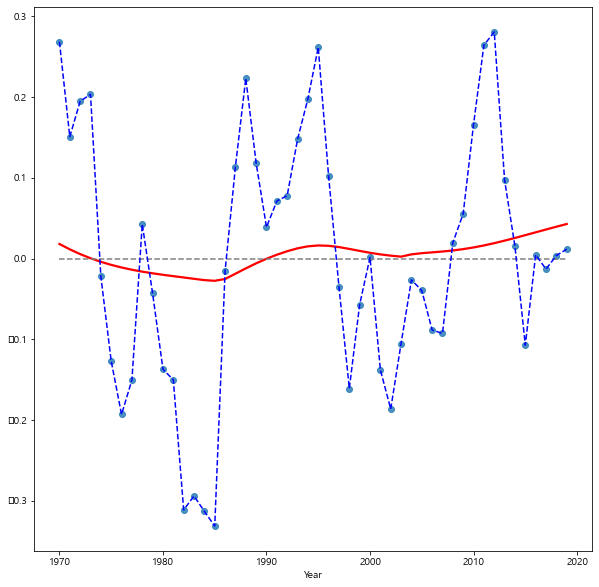

In [373]:
Y_predict = model.predict(japan)
residual = japan['lnY'] - Y_predict

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')


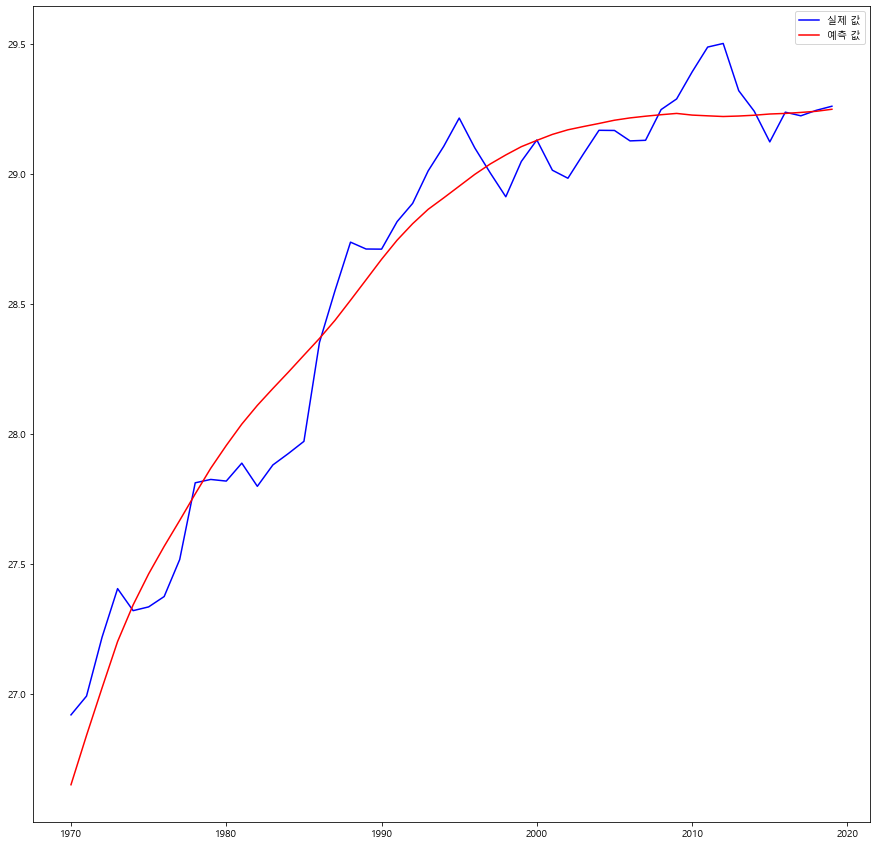

In [374]:
plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(japan.index, japan['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')
plt.legend()


c:\Users\kimjonghwi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


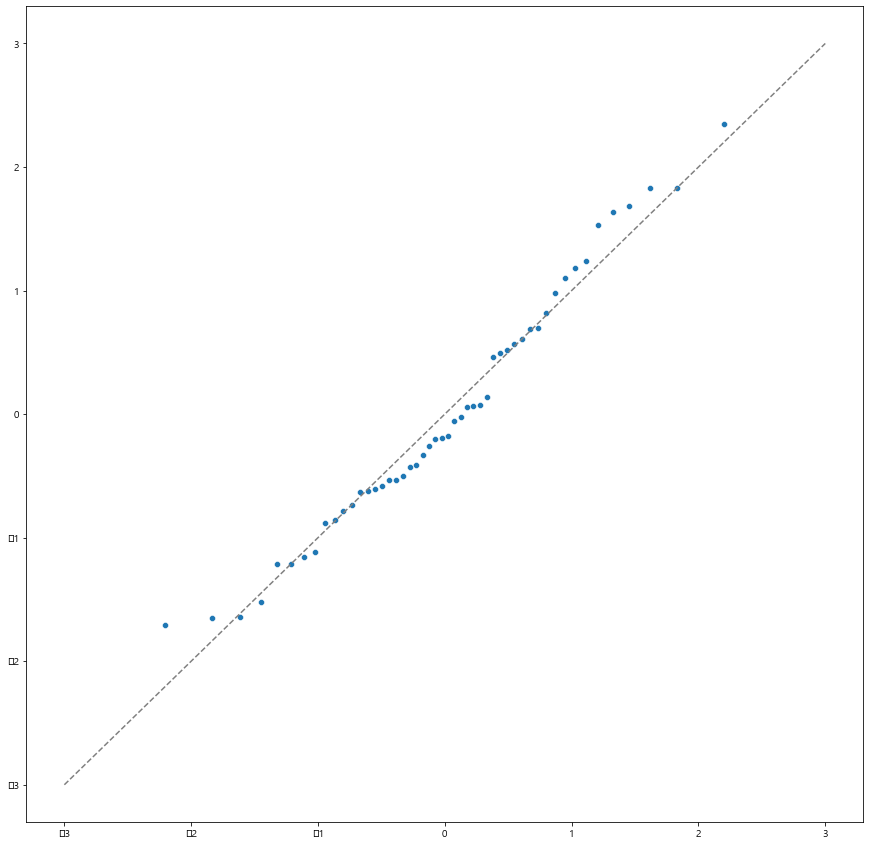

In [355]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [85]:
Y = usa['lnY'].to_numpy()
Y_avg = np.average(Y)
X = usa[['intercept', 'trend', 'lnK', 'lnL']].to_numpy()

N = len(usa)
K = 4

XX = X.transpose().dot(X)
XX_inv = np.linalg.inv(XX)
XY = X.transpose().dot(Y)

beta = XX_inv.dot(XY)

In [86]:
for b in beta:
    print(np.around(b,3))

7.17
0.0
0.729
0.52


In [87]:
Y_hat = X.dot(beta)
Y_hat_avg = np.average(Y_hat)
resid = Y - Y_hat

SSR = resid**2
SSE = (Y_hat - Y_hat_avg)**2
SST = (Y - Y_avg)**2
SST

e_std_dev = SSR.sum()/(N-K)
R_square = SSE.sum()/SST.sum()
adj_R_square = 1 - ( (SSR.sum()/(N-K)) / (SST.sum()/N) )



beta_var = e_std_dev * XX_inv
beta_var_diag =np.diag(beta_var)
beta_var_inv = np.linalg.inv(beta_var)
beta_var_inv_dig = np.diag(beta_var_inv)

std_dev_beta = np.sqrt(beta_var_diag)
t_value = beta/std_dev_beta





In [88]:
adj_R_square

0.9985356365708642

In [89]:
R = np.array([[0, 0, 1, 1], [1,0,0,0]])
r = np.array([1, 0])

#np.linalg.inv(np.matmul(R, np.matmul(XX_inv, R.transpose())))

RVR_inv = np.linalg.inv(np.matmul(np.matmul(R, beta_var), R.transpose()))
RVR_inv

Rb = (np.matmul(R, beta)-r).transpose()

np.matmul(RVR_inv, Rb)

chai_sq = np.matmul(Rb.transpose(), np.matmul(RVR_inv, Rb))
chai_sq

#F = chai_sq / 2


#pd.DataFrame(chai_sq)


29751.17958153742

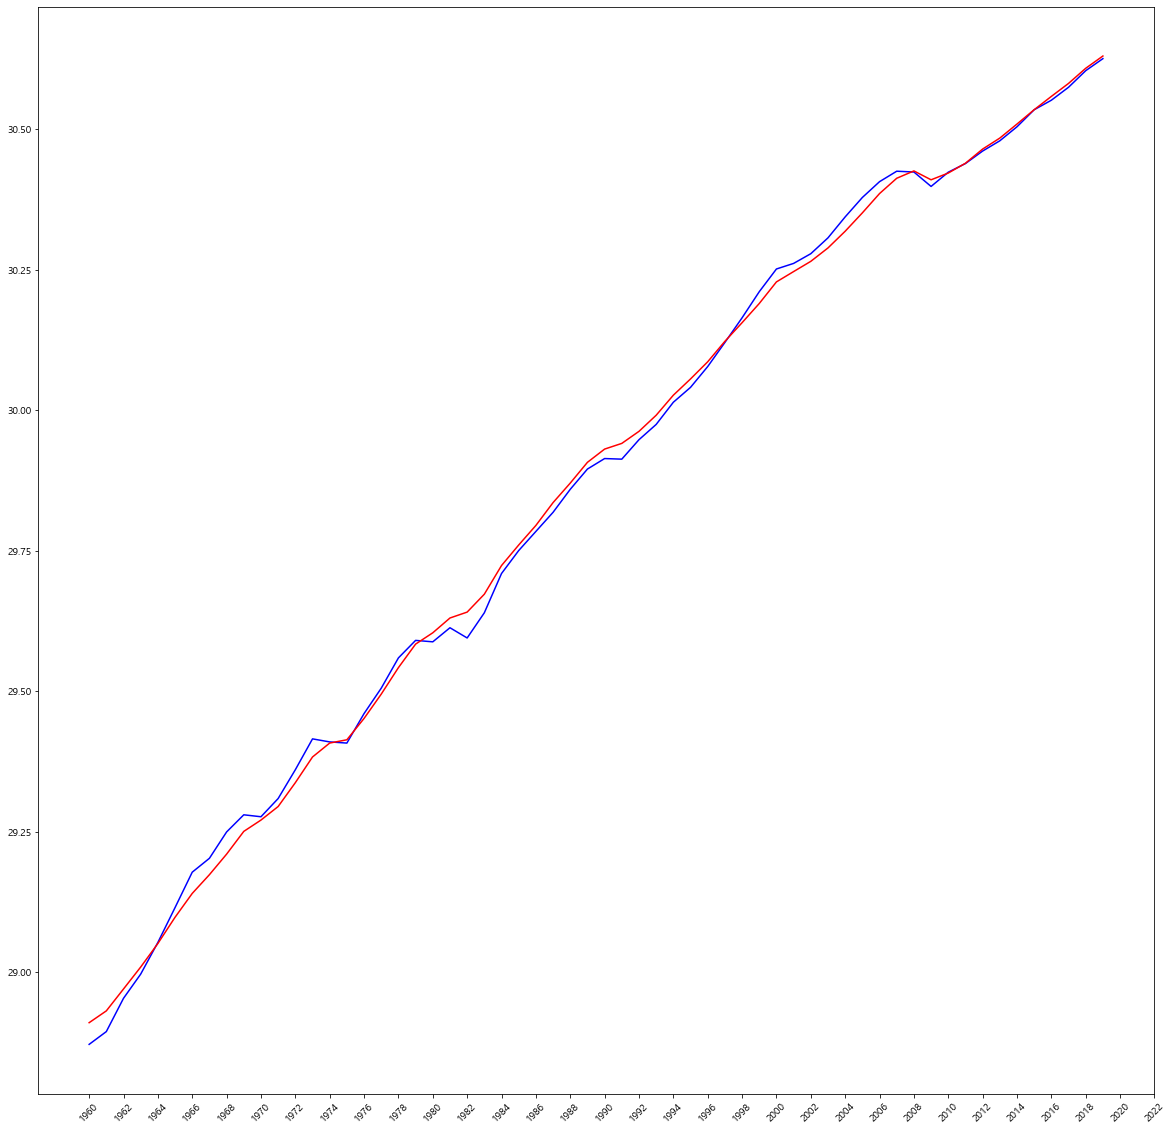

In [90]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(usa.index, Y, color='blue')
plt.plot(usa.index, Y_hat, color='red')
plt.xticks(range(1960, 2024, 2), rotation=45)
plt.show()

In [91]:
Y = usa['lnY'].to_numpy()
Y_avg = np.average(Y)
X = usa[['intercept', 'trend', 'lnK', 'lnL', 'first_dummy']].to_numpy()

N = 50
K = 5

XX = X.transpose().dot(X)
XX_inv = np.linalg.inv(XX)
XY = X.transpose().dot(Y)

beta = XX_inv.dot(XY)



In [92]:
Y_hat = X.dot(beta)
Y_hat_avg = np.average(Y_hat)
resid = Y - Y_hat

SSR = resid**2
SSE = (Y_hat - Y_hat_avg)**2
SST = (Y - Y_avg)**2
SST

e_std_dev = SSR.sum()/(N-K)
R_square = SSE.sum()/SST.sum()
adj_R_square = 1 - ( (SSR.sum()/(N-K)) / (SST.sum()/N) )


In [93]:
beta_var = e_std_dev * XX_inv
beta_var_diag =np.diag(beta_var)
beta_var_inv = np.linalg.inv(beta_var)
beta_var_inv_dig = np.diag(beta_var_inv)

std_dev_beta = np.sqrt(beta_var_diag)
t_value = beta/std_dev_beta

In [94]:
R = np.array([0, 0, 1, 1])
r = np.array([1])

In [95]:
np.linalg.inv(np.matmul(R, np.matmul(XX_inv, R.transpose())))

RVR_inv = np.linalg.inv(np.matmul(np.matmul(R, beta_var), R.transpose()))
RVR_inv

Rb = (np.matmul(R, beta)-r).transpose()

np.matmul(RVR_inv, Rb)

chai_sq = np.matmul(Rb.transpose(), np.matmul(RVR_inv, Rb))
chai_sq

#F = chai_sq / 2

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 5)

In [ ]:
pd.DataFrame(chai_sq)

,0
0,3.090227


In [ ]:
cu.breaks_cusumolsresid(resid, ddof=4)

(1.1249663131045695, 0.15906296097793685, [(1, 1.63), (5, 1.36), (10, 1.22)])

In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(usa.index, Y, color='blue')
plt.plot(usa.index, Y_hat, color='red')
plt.xticks(range(1960, 2024, 2), rotation=45)
plt.show()

NameError: name 'usa' is not defined

c:\Users\kimjo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\kimjo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kimjo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


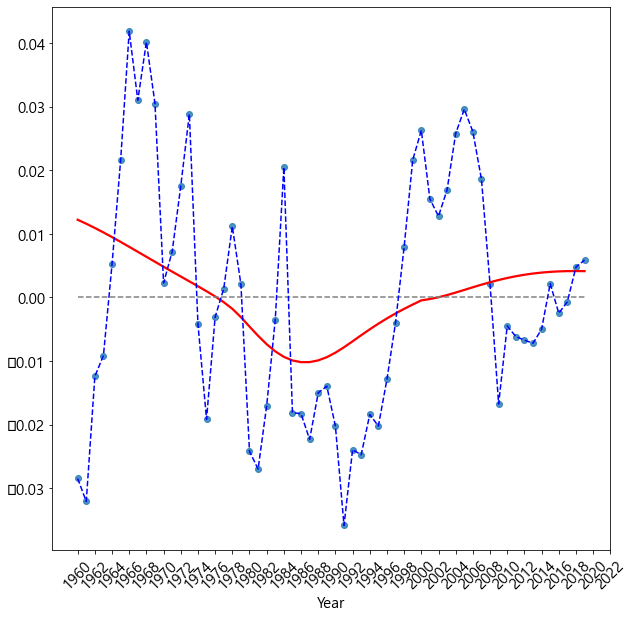

In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(usa.index, resid, lowess=True, line_kws={'color': 'red'})
plt.plot([usa.index.min(), usa.index.max()], [0, 0], '--', color='grey')
plt.plot(usa.index, resid, '--', color='blue')
plt.xticks(range(1960, 2024, 2), rotation=45)
plt.show()